## Prep

In [1]:
# Import packages
import pandas as pd
import plotly.graph_objects as go
import networkx as nx
from ds_common_utils.aux.io.snowflake_tools import SnowflakeTools
from math import log
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.pyplot as plt
import community.community_louvain as community_louvain
import numpy as np

In [2]:
# Get connection
con = SnowflakeTools().get_snowflake_ctx(
     method = 'token',
    user = '250807',
    role = 'INSIGHT_ANALYST_MERCH_DE_GENERAL_PRD',
    warehouse = 'INSIGHT_ANALYST_WH'
)
with open('sql/item_association.sql', 'r') as query:
        df = pd.read_sql_query(query.read(), con)

snowflake_tools - 2025-07-04 11:39:24.849135+10:00 - Generating new token with 'INSIGHT_ANALYST_MERCH_DE_GENERAL_PRD' role and 'SESSION:ROLE-ANY' scope...
snowflake_tools - 2025-07-04 11:39:30.562115+10:00 - Saved token with '2025-07-04 15:39:30+10:00' expiry...


## Explore

400 RODENT PEST CONTROL has 153321 transactions

In [3]:
RPC_df = df[(df['PRIMARY_ID'] == '400 RODENT PEST CONTROL') | (df['SECONDARY_ID'] == '400 RODENT PEST CONTROL')]
# RPC_df

In [24]:
# Combine both PRIMARY_ID and SECONDARY_ID 
primary_df = RPC_df[['PRIMARY_ID', 'PRIMARY_TRANSACTIONS']].rename(
    columns={'PRIMARY_ID': 'sub_dept', 'PRIMARY_TRANSACTIONS': 'transactions'}
)
secondary_df = RPC_df[['SECONDARY_ID', 'SECONDARY_TRANSACTIONS']].rename(
    columns={'SECONDARY_ID': 'sub_dept', 'SECONDARY_TRANSACTIONS': 'transactions'}
)

# Concatenate and deduplicate
combined_df = pd.concat([primary_df, secondary_df])
combined_df = combined_df.drop_duplicates(subset=['sub_dept'])
combined_df = combined_df[(combined_df['sub_dept'] != '400 RODENT PEST CONTROL')]

# Group by segment and class, then calculate average transactions
cross_shop_df = combined_df.groupby(['sub_dept'], as_index=False).agg(
    transactions=('transactions', 'max')
)

# Calculate exposure percentage
cross_shop_df['exposure_pct'] = (
    cross_shop_df['transactions'] / 153321 * 100
)

# Sort result
cross_shop_df = cross_shop_df.sort_values(['transactions'], ascending=False).reset_index(drop=True)

cross_shop_df.head(20)

,sub_dept,transactions,exposure_pct
0,400 CLEANING CHEMICALS,10775,7.027739
1,400 PAINT PREPARATION,9400,6.130928
2,400 CLEANING ACCESSORIES,8794,5.735679
3,400 GARDEN PEST CONTROL,8434,5.500877
4,400 CRAWLING PEST CONTROL,8106,5.286947
5,400 GROWING MEDIA,7109,4.636677
6,400 FLYING PEST CONTROL,5912,3.855962
7,401 BATTERIES,5672,3.699428
8,400 BRUSHWARE AND MOPS,5371,3.503108
9,400 PROPAGATION,5344,3.485498


In [25]:
output_path = 'top_sub_dept_transaction.csv'
cross_shop_df.to_csv(output_path, index=False)

In [26]:
# Extract the top 20 sub-departments by transaction count
top20 = cross_shop_df.nlargest(20, 'transactions').reset_index(drop=True)['sub_dept'].tolist()

## Parameter Tuning

In [376]:
TRX_THRESHOLD = 20 # Min N frequent pairs
QUANTILE = 0.95 # Nth percentile of metric similarity
TOP_N = 1 # top-N associated item classes per primary class
RESO = 0.5 # >1.0 → more, smaller communities
METRIC = 'LIFT' # LIFT or JACCARD

## Working

In [377]:
# filtered_df = df[(df['PRIMARY_ID'] != '400 RODENT PEST CONTROL' ) & ( df['SECONDARY_ID']!='400 RODENT PEST CONTROL')]

# Filter rows where either primary or secondary is in the top-20 list
filtered_df = df[
    (
        df['PRIMARY_ID'].isin(top20) |
        df['SECONDARY_ID'].isin(top20)
    )
    &
    (df['PRIMARY_ID'] != '400 RODENT PEST CONTROL') &
    (df['SECONDARY_ID'] != '400 RODENT PEST CONTROL')
].reset_index(drop=True)

filtered_df = filtered_df[filtered_df['PAIR_TRANSACTIONS'] >= TRX_THRESHOLD]
threshold = filtered_df[METRIC].quantile(QUANTILE)
filtered_df = filtered_df[filtered_df[METRIC] >= threshold]
top_edges = filtered_df.sort_values(METRIC, ascending=False).groupby('PRIMARY_ID').head(TOP_N)


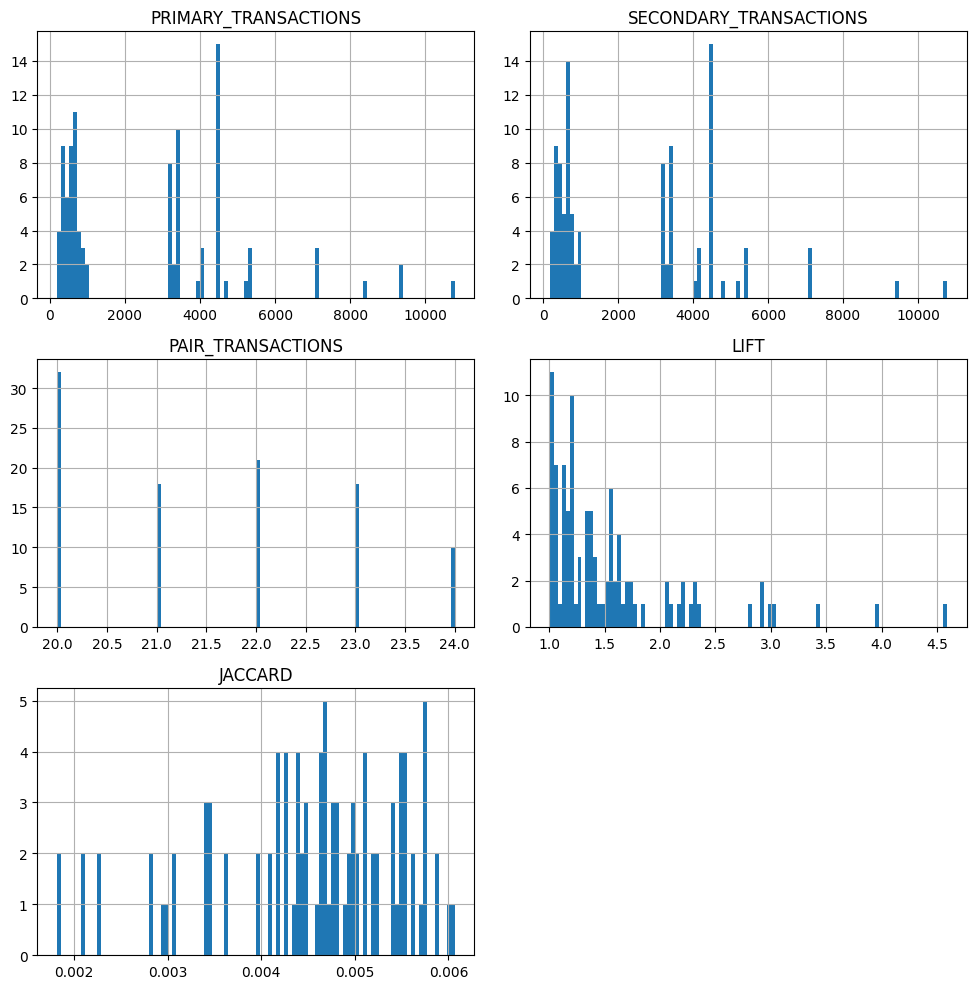

In [378]:
# Plot histograms of numerical columns
numeric_cols = filtered_df.select_dtypes(include='number').columns
filtered_df[numeric_cols].hist(bins=100, figsize=(10, 10), layout=(3, 2))
plt.tight_layout()
plt.show()

In [379]:
filtered_df.sort_values(by='PAIR_TRANSACTIONS', ascending=False)

,PRIMARY_ID,SECONDARY_ID,PRIMARY_TRANSACTIONS,SECONDARY_TRANSACTIONS,TRX_START_MONTH,TRX_END_MONTH,PAIR_TRANSACTIONS,LIFT,JACCARD
7732,400 UNDERCOAT,400 PAINT APPLICATORS,362,4471,2024-06-01,2025-05-01,24,2.275556,0.004991
5771,400 PAINT APPLICATORS,400 EXTERIOR WOODCARE,4471,682,2024-06-01,2025-05-01,24,1.207846,0.004679
5901,400 PAINT APPLICATORS,400 UNDERCOAT,4471,352,2024-06-01,2025-05-01,24,2.340203,0.005001
2638,400 EXTERIOR WOODCARE,400 PAINT APPLICATORS,682,4471,2024-06-01,2025-05-01,24,1.207846,0.004679
5812,400 PAINT APPLICATORS,400 INTERIOR BROADWALL PAINT,4471,645,2024-06-01,2025-05-01,24,1.277134,0.004713
5860,400 PAINT APPLICATORS,400 PLASTER AND ACCESSORIES,4471,556,2024-06-01,2025-05-01,24,1.481567,0.004797
5848,400 PAINT APPLICATORS,400 PAINT PROTECTION,4471,734,2024-06-01,2025-05-01,24,1.122277,0.004632
6428,400 PAINT PROTECTION,400 PAINT APPLICATORS,773,4471,2024-06-01,2025-05-01,24,1.065655,0.004598
6668,400 PLASTER AND ACCESSORIES,400 PAINT APPLICATORS,589,4471,2024-06-01,2025-05-01,24,1.398559,0.004766
5052,400 INTERIOR BROADWALL PAINT,400 PAINT APPLICATORS,714,4471,2024-06-01,2025-05-01,24,1.153713,0.004650


In [380]:
mode='lines',
line_shape='spline'
    
# Build node size map from your DataFrame
node_size_map = dict(zip(top_edges['PRIMARY_ID'], top_edges['PRIMARY_TRANSACTIONS']))

# Convert values to NumPy array
sizes = np.array(list(node_size_map.values()))

# Use np.ptp instead of .ptp()
norm_sizes = (sizes - sizes.min()) / np.ptp(sizes)  # scale to 0–1
scaled_sizes = 10 + norm_sizes * 30                 # scale to 10–40

# Final size map: Product ID → Scaled Size
scaled_size_map = dict(zip(node_size_map.keys(), scaled_sizes))

# Step 1: Build the full graph
G = nx.Graph()
for _, row in top_edges.iterrows():
    G.add_edge(row['PRIMARY_ID'], row['SECONDARY_ID'], weight=row[METRIC])

# Step 2: Louvain community detection
partition = community_louvain.best_partition(G, weight=METRIC, resolution=RESO)

# Step 3: Layout
pos = nx.spring_layout(G, weight='weight', seed=42
                      )

# Step 4: Edge trace (no filter on weight)
edge_x, edge_y = [], []
for u, v in G.edges():
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=1, color='gray'),
    hoverinfo='none',
    mode='lines'
)

# Step 5: Node trace with Louvain cluster coloring
color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']  # Extend if you expect >10 clusters

node_x, node_y, node_color, node_size, hover_text = [], [], [], [], []

for node in G.nodes():
    x, y = pos[node]
    cluster = partition[node]
    size = scaled_size_map.get(node, 10)  # default to small if missing

    node_x.append(x)
    node_y.append(y)
    node_color.append(color_list[cluster % len(color_list)])
    node_size.append(size)
    hover_text.append(f"Product ID: {node}<br>Cluster: {cluster}<br>Transactions: {int(size)}")

node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers+text',
    hoverinfo='text',
    text=[str(node) for node in G.nodes()],
    textposition='top center',
    marker=dict(
        color=node_color,
        size=node_size,  # <--- size now dynamic!
        line=dict(width=2, color='black')
    ),
    textfont=dict(
    size=16,          # increase for visibility
    color='black',
    family='Arial'
)
)
# Step 6: Plot
fig = go.Figure(
    data=[edge_trace, node_trace],
    layout=go.Layout(
        width=1200,          # increase width
    height=800, 
        title=dict(text='Louvain Product Clustering (All Edges)', x=0.5, font=dict(size=16)),
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20, l=20, r=20, t=40),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
    )
)

## Results

In [381]:
fig.show()

In [382]:
# Merge community partition info with filtered edges
partition_df = pd.DataFrame.from_dict(partition, orient='index', columns=['segment']).reset_index()
partition_df.rename(columns={'index': 'PRIMARY_ID'}, inplace=True)

# Merge and deduplicate
labelled_df = filtered_df.merge(partition_df, on='PRIMARY_ID', how='left')
labelled_df = labelled_df[['PRIMARY_ID', 'SECONDARY_ID', 'PRIMARY_TRANSACTIONS', 'SECONDARY_TRANSACTIONS', 'PAIR_TRANSACTIONS', METRIC, 'segment']].drop_duplicates()
labelled_df = labelled_df.sort_values(by=['segment', METRIC]).reset_index(drop=True)

# Expand display limits
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
# display(labelled_df)

In [383]:
output_path = 'segment_pair_all.csv'
labelled_df.to_csv(output_path, index=False)

In [384]:
# Combine both PRIMARY_ID and SECONDARY_ID with associated segment
primary_df = labelled_df[['segment', 'PRIMARY_ID', 'PRIMARY_TRANSACTIONS']].rename(
    columns={'PRIMARY_ID': 'sub_dept', 'PRIMARY_TRANSACTIONS': 'transactions'}
)
secondary_df = labelled_df[['segment', 'SECONDARY_ID', 'SECONDARY_TRANSACTIONS']].rename(
    columns={'SECONDARY_ID': 'sub_dept', 'SECONDARY_TRANSACTIONS': 'transactions'}
)

# Concatenate and deduplicate
combined_df = pd.concat([primary_df, secondary_df])
combined_df = combined_df.drop_duplicates(subset=['segment', 'sub_dept'])

# Group by segment and class, then calculate average transactions
exposure_df = combined_df.groupby(['segment', 'sub_dept'], as_index=False).agg(
    transactions=('transactions', 'max')
)

# Calculate exposure percentage
exposure_df['exposure_pct'] = (
    exposure_df['transactions'] / 1116333 * 100
)

# Rename for final output
exposure_df = exposure_df.rename(columns={'segment': 'cluster'})

# Sort result
exposure_df = exposure_df.sort_values(['cluster', 'transactions'], ascending=False).reset_index(drop=True) 

In [391]:
exposure_df.sort_values(['transactions'], ascending=False)

,cluster,sub_dept,transactions,exposure_pct
0,10,400 CLEANING CHEMICALS,10775,0.965214
14,6,400 PAINT PREPARATION,9400,0.842043
4,8,400 GARDEN PEST CONTROL,8434,0.755509
38,3,400 GROWING MEDIA,7109,0.636817
5,8,400 GROWING MEDIA,7109,0.636817
28,4,400 BRUSHWARE AND MOPS,5371,0.481129
9,7,400 FERTILISERS,5181,0.464109
48,1,401 BBQ ACCESSORIES,4743,0.424873
17,5,400 PAINT APPLICATORS,4471,0.400508
44,2,400 PAINT APPLICATORS,4471,0.400508


In [392]:
output_path = 'segment_exposure_all.csv'
exposure_df.to_csv(output_path, index=False)

## Regroup segment

In [393]:
# Define merged super-segment mapping
merged_mapping = {
    0:  'Finish & Protect',        # interior/exterior finishing trades
    1:  'Exclude',                 # BBQ impulse buys
    2:  'Finish & Protect',        # lighting & prep work
    3:  'Garden & Landscape',      # horticultural installs & irrigation
    4:  'Garden & Landscape',      # fertilisers, gloves, garden consumables
    5:  'Clean & Treat',           # deep-clean & spot-repair
    6:  'Finish & Protect',        # fit-out bundle of hooks, hardware, applicators
    7:  'Finish & Protect',        # paint prep & carpentry panels
    8:  'Garden & Landscape',      # pure garden-pest cluster
    9:  'Garden & Landscape',      # planting & planter installs
   10:  'Clean & Treat'            # cleaning chemicals & plumbing tools
}

# Make a copy of your original exposure_df
regroup_df = exposure_df.copy()

# Apply the macro-segment labels to the cluster column
regroup_df['Macro-segment'] = regroup_df['cluster'].map(merged_mapping)

# Reorder columns to make the output cleaner
regroup_df = regroup_df[
    ['Macro-segment', 'sub_dept', 'transactions', 'exposure_pct']
]

# Sort the DataFrame by macro-segment and exposure percent (descending)
regroup_df = regroup_df.sort_values(
    ['Macro-segment', 'exposure_pct'],
    ascending=[True, False]
).reset_index(drop=True)

In [394]:
regroup_df.groupby(['Macro-segment'], as_index=False).agg(TOTAL_TRANSACTIONS=('transactions', 'sum'))

,Macro-segment,TOTAL_TRANSACTIONS
0,Clean & Treat,28219
1,Exclude,4976
2,Finish & Protect,42179
3,Garden & Landscape,48634


In [395]:
regroup_df

,Macro-segment,sub_dept,transactions,exposure_pct
0,Clean & Treat,400 CLEANING CHEMICALS,10775,0.965214
1,Clean & Treat,400 PAINT APPLICATORS,4471,0.400508
2,Clean & Treat,401 POWER USAGE ACCESSORIES,3377,0.302508
3,Clean & Treat,400 HOOKS,3178,0.284682
4,Clean & Treat,402 PADLOCKS AND CABLES,954,0.085458
5,Clean & Treat,400 ROPE,934,0.083667
6,Clean & Treat,400 CRAFT AND PROJECTS,926,0.082950
7,Clean & Treat,400 WALL AND FLOOR ANCHORS,729,0.065303
8,Clean & Treat,400 BRACKETS,685,0.061362
9,Clean & Treat,401 CABINET HARDWARE,681,0.061003


In [396]:
output_path = 'segment_exposure_all_regrouped.csv'
regroup_df.to_csv(output_path, index=False)